# Access data from the NECOFS (New England Coastal Ocean Forecast System) via OPeNDAP

Demonstration using the NetCDF4-Python library to access velocity data from a triangular grid ocean model (FVCOM) via OPeNDAP, specifying the desired URL, time, layer and lat/lon region of interest.  The resulting plot of forecast velocity vectors over color-shaded bathymetry is useful for a variety of recreational and scientific purposes. 

NECOFS (Northeastern Coastal Ocean Forecast System) is run by groups at the University of Massachusetts Dartmouth and the Woods Hole Oceanographic Institution, led by Drs. C. Chen, R. C. Beardsley, G. Cowles and B. Rothschild. Funding is provided to run the model by the NOAA-led Integrated Ocean Observing System and the State of Massachusetts.

NECOFS is a coupled numerical model that uses nested weather models, a coastal ocean circulation model, and a wave model. The ocean model is a volume-mesh model with horizontal resolution that is finer in complicated regions. It is layered (not depth-averaged) and includes the effects of tides, winds, and varying water densities caused by temperature and salinity changes.

* Model description: http://fvcom.smast.umassd.edu/research_projects/NECOFS/model_system.html
* THREDDS server with other forecast and archive products: http://www.smast.umassd.edu:8080/thredds/catalog.html

### Swim route.

In [1]:
lon_track = [-70.89015, -70.927933, -70.951417, -70.976217, -70.99915, -71.03485]
lat_track = [42.3274, 42.31615, 42.3148, 42.3093, 42.322633, 42.3287]

### Dictionary with  model_name: OPeNDAP Data URL.

In [2]:
base = 'http://www.smast.umassd.edu:8080/thredds/dodsC/{}'.format

models = dict(
    Massbay_forecast=base('FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'),
    GOM3_Forecast=base('FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'),
    Massbay_forecast_archive=base('fvcom/archives/necofs_mb'),
    GOM3_30_year_hindcast=base('fvcom/hindcasts/30yr_gom3')
)

### DAP Data URL: MassBay GRID.

In [3]:
from netCDF4 import Dataset

url = models['Massbay_forecast']

nc = Dataset(url)

print(', '.join(nc.variables.keys()))

x, y, lon, lat, xc, yc, lonc, latc, siglay, h, nv, time, Times, zeta, nbe, aw0, awx, awy, u, v, ww, ua, va, temp, salinity, fvcom_mesh


### Take a look at the "metadata" for the variable "u".

In [4]:
print(nc['temp'])

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, siglay, node)
    long_name: temperature
    standard_name: sea_water_potential_temperature
    units: degrees_C
    grid: fvcom_grid
    coordinates: time siglay lat lon
    type: data
    coverage_content_type: modelResult
    mesh: fvcom_mesh
    location: node
unlimited dimensions: time
current shape = (145, 10, 98432)
filling off



### Get desired time step.

In [5]:
from netCDF4 import date2index, num2date
from datetime import datetime, timedelta

# Desired time for snapshot in UTC
# ....right now (or some number of hours from now) ...

start = datetime.utcnow() + timedelta(hours=24)

# ... or specific time (UTC)
# start = dt.datetime(2016,8,19,12,0)  #Note: EDT = UTC - 4 hours , EST = UTC -5 hours

time_var = nc['time']
itime = date2index(start, time_var, select='nearest')

dtime = num2date(time_var[itime], time_var.units)

print('Time in UTC: {}'.format(dtime))

Time in UTC: 2016-09-15 19:01:52.500000


### Get `lon`, `lat` coordinates for nodes and center, the `depth`, and the connectivity array (`nv`).


In [6]:
lat = nc['lat'][:]
lon = nc['lon'][:]

latc = nc['latc'][:]
lonc = nc['lonc'][:]

nv = nc['nv'][:].T - 1

h = nc['h'][:]

In [7]:
from matplotlib.tri import Triangulation

tri = Triangulation(lon, lat, triangles=nv)

### Boston Light Swim figure.

In [8]:
import numpy as np

levels = np.arange(64, 72, 1)  # Temperature contours to plot [48 to 65 in intervals of 1].
bbox = [-71.05, -70.82, 42.28, 42.38]  # Region to plot.
maxvel = 1.0  # Velocity arrow scale.
subsample = 3  # Subsampling of velocity vectors.

### Find velocity points in bounding box and get random velocity vectors.

In [9]:
ind = np.argwhere(
    (lonc >= bbox[0]) & (lonc <= bbox[1]) &
    (latc >= bbox[2]) & (latc <= bbox[3])
)

np.random.shuffle(ind)

Nvec = int(len(ind) / subsample)

idv = ind[:Nvec]

In [10]:
ilayer = 0  # [0 = surface, -1 = bottom]

u = nc['u'][itime, ilayer, :]
v = nc['v'][itime, ilayer, :]

# Convert m/s to knots
u *= 1.94
v *= 1.94

In [11]:
t = nc['temp'][itime, ilayer, :]

# Convert from Celsius to Fahrenheit.
t = 32 + t*9/5.

### Tricontourf plot of water depth with vectors on top.

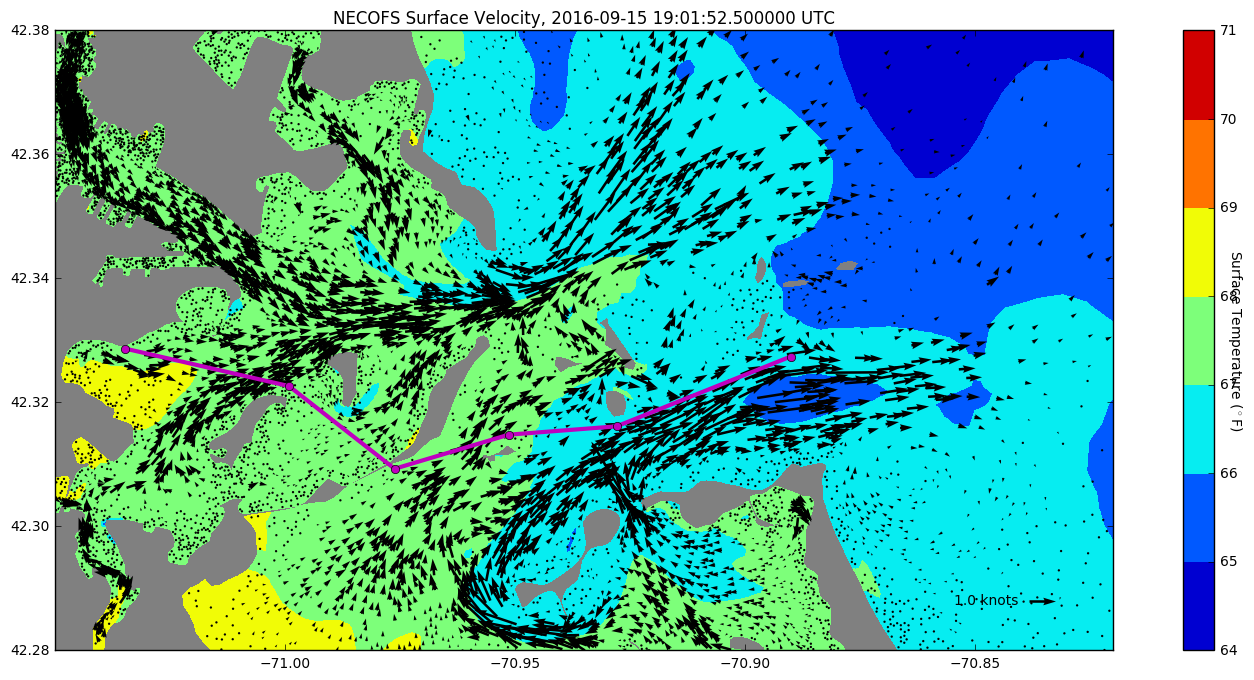

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

merc = 1.0 / np.cos(lat.mean()*np.pi/180.0)
fig, ax = plt.subplots(figsize=(18, 8),
                       subplot_kw=dict(aspect=merc))

cs = ax.tricontourf(tri, t, levels=levels, shading='faceted')
ax.axis(bbox)
ax.patch.set_facecolor('0.5')
cbar = fig.colorbar(cs)
cbar.set_label(r'Surface Temperature ($^\circ $F)', rotation=-90)
Q = ax.quiver(lonc[idv], latc[idv], u[idv], v[idv], scale=40)

maxstr = '%3.1f knots' % maxvel
qk = ax.quiverkey(Q, 0.92, 0.08, maxvel, maxstr, labelpos='W')
ax.set_title('NECOFS Surface Velocity, %s UTC' % (dtime))
pt = ax.plot(lon_track, lat_track, 'm-o', linewidth=3)

In [13]:
print('Minimum temperature: {:0.2f}'.format(t.min()))
print('Maximum temperature: {:0.2f}'.format(t.max()))

Minimum temperature: 57.46
Maximum temperature: 76.48


In [14]:
# Convert to feet.
h *= -0.3042

hlevels = np.arange(-100, 5, 5)

### Tricontourf plot of water depth with vectors on top.

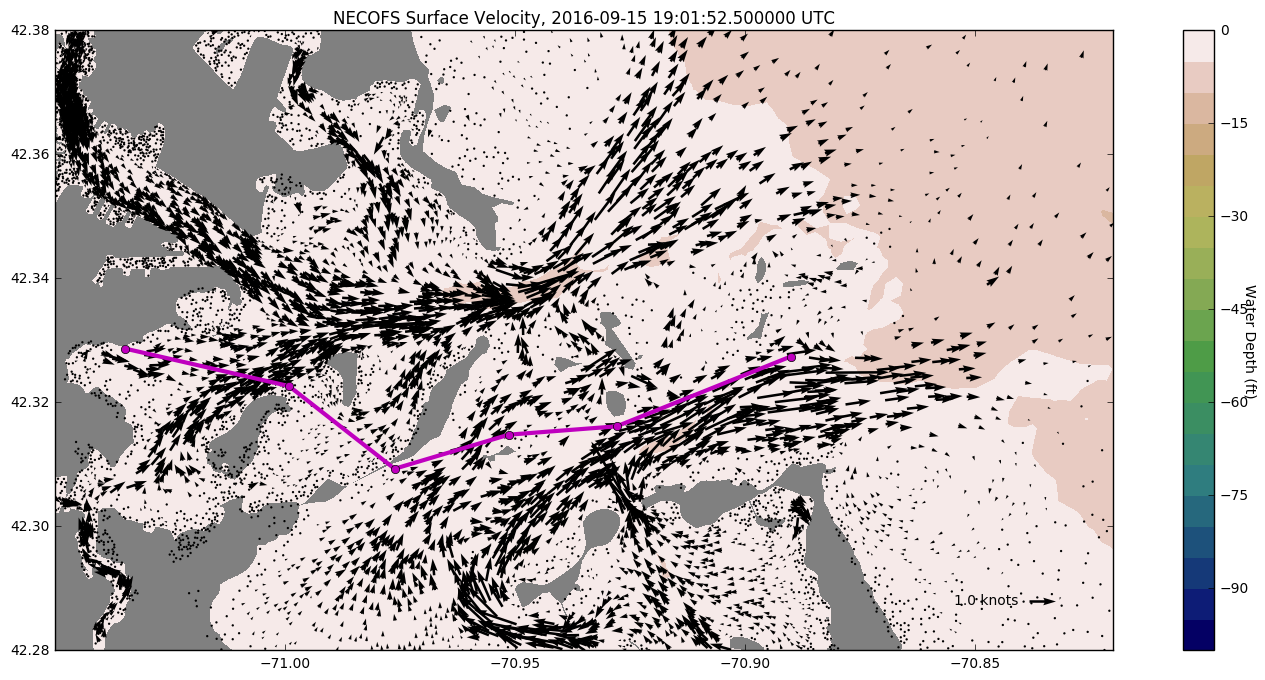

In [15]:
fig, ax = plt.subplots(figsize=(18, 8),
                       subplot_kw=dict(aspect=merc))

cs = ax.tricontourf(tri, h, levels=hlevels, shading='faceted', cmap=plt.cm.gist_earth)
ax.axis(bbox)
ax.patch.set_facecolor('0.5')
cbar = fig.colorbar(cs)
cbar.set_label('Water Depth (ft)', rotation=-90)
Q = ax.quiver(lonc[idv], latc[idv], u[idv], v[idv], scale=40)

maxstr = '%3.1f knots' % maxvel
qk = ax.quiverkey(Q, 0.92, 0.08, maxvel, maxstr, labelpos='W')
ax.set_title('NECOFS Surface Velocity, %s UTC' % (dtime))
pt = ax.plot(lon_track, lat_track, 'm-o', linewidth=3)